In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import rc, rcParams
from scipy import interpolate
import matplotlib.ticker as mticker
import math
import time
import scipy.optimize as optimize
from scipy.integrate import quad

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 2

In [3]:
L_ref = 120.                 # chosen reference length, in [pc]
#d_cyg_ref = 1.5e+3           # reference distance of the Cygnus-X region, in [pc]
conv_pc_cm = 3.086e+18       # conversion factor from [pc] to [cm]
conv_cm_pc = 3.24e-19        # conversion factor from [cm] to [pc]
conv_s_yr = 3.171e-8         # conversion factor from [sec] to [yr]
conv_yr_sec = 3.154e+7       # conversion factor from [yr] to [sec]
conv_sec_yr = 1/conv_yr_sec
conv_rad_degree = 57.2958    # conversion factor from [rad] to [deg]
conv_erg_GeV = 624.151
conv_GeV_erg = 1/conv_erg_GeV
c = 2.998e+10                # speed of light, in [cm/s]
B_field = 3 # microGauss
k_B = 8.617e-5 # eV/K
sigmaT = 6.652e-25 # cm^2
m_e = 0.000510998918  # electron mass in [GeV c^{-2}]
m_ec2 = 0.511*1e6 #eV/c^2 
U_B = 0.224*((B_field/3)**2) *1e-9 # eV/cm^3 --> GeV/cm^3 and B_field in microGauss
U_CMB = 0.26 *1e-9  # eV/cm^3 --> GeV/cm^3 
U_IR = 0.25 *1e-9   # eV/cm^3 --> GeV/cm^3 
U_Opt = 0.055 *1e-9 # eV/cm^3 --> GeV/cm^3 
U_UV1 = 0.37 *1e-9  # eV/cm^3 --> GeV/cm^3 
U_UV2 = 0.23 *1e-9  # eV/cm^3 --> GeV/cm^3 
U_UV3 = 0.12 *1e-9  # eV/cm^3 --> GeV/cm^3 



Emax = 2e5
Emin = 200
Ekin_fac = 1.3
print(Emin, Emax, Ekin_fac)
dimE = int( (np.log(Emax) - np.log(Emin)) / np.log(Ekin_fac)) + 2 # I added another more point to pass E_max!
print(dimE)
E = [Emin*(Ekin_fac**i) for i in range(0,dimE)]
E = np.array(E)
dE = (np.append(E[1:], Emin*(Ekin_fac**dimE)) - E)/E


# Diffusion coefficient #
D_ref = 3.8e28 ## this is [cm^2/s]
delta = 1./3. #0.5

print(r'Our reference diffusion coefficient (at 1 GeV) is: D_ref =', D_ref, r'cm^2/s =', 
      D_ref*((conv_cm_pc**2)/conv_s_yr), r'$pc^2/yr$')
print("")
#D = (D_ref*(E**delta)/(L_ref*c*conv_cm_pc/conv_s_yr))*((conv_cm_pc**2)/conv_s_yr) 
    ## Here, c is in units of [pc/yr] and L of parsecs. Then, we convert D in [cm^2/s] to be [pc^2/yr]
D = (D_ref*(E**delta))

200 200000.0 1.3
28
Our reference diffusion coefficient (at 1 GeV) is: D_ref = 3.8e+28 cm^2/s = 0.12579905392620627 $pc^2/yr$



# <center>Energy-loss rate, with Klein-Nishina correction
    
$$
\begin{align}
& b(E) \equiv \frac{dE}{dt} = - \frac{4}{3} \sigma_T c \left[ f^{KN}_{i} U_i + U_B \right] \, \left( \frac{E}{m_e c^2} \right)^2 \\[10 pt]
& f^{KN}_{i} = \frac{ \frac{45}{64 \pi^2} \left( \frac{m_e c^2}{k_B T_i} \right)^2 }{ \frac{45}{64 \pi^2} \left( \frac{m_e c^2}{k_B T_i} \right)^2 + \left( \frac{E}{m_e c^2} \right)^2 }
\end{align}
$$

In [9]:
### Klein-Nishina factor, from Evoli et al. arXiv:2007.01302 (2020) ###
#######################################################################
ISRF_components = ['CMB', 'IR', 'OPT', 'UV_1', 'UV_2', 'UV_3']
T_ISRF = [2.725, 33.07, 313.32, 3249.3, 6150.4, 23209.0]            # in [K]
U_ISRF = [0.26e-9, 0.25e-9, 0.055e-9, 0.37e-9, 0.23e-9, 0.12e-9]    # energy density of the contributions, in [GeV cm^(-3)]

B_field = 3.2e-6         # magnetic field, in [G]
U_B = ( B_field**2 / (8*np.pi) ) * conv_erg_GeV
print('B field =', B_field, '[G], magnetic energy density =', U_B, '[GeV cm^{-3}]')
print('')

k_boltzmann = k_B*1e-9
factor_ratio = ( 45 / (64*np.pi**2) )
def loss_rate_KN(Energy):
    
    f_KN_times_U = 0.
    
    for i in range (len(T_ISRF)):

        f_KN_times_U_single = ( (factor_ratio * ( m_e / (k_boltzmann*T_ISRF[i]) )**2) / ( (factor_ratio * ( m_e / (k_boltzmann*T_ISRF[i]) )**2) + (Energy/m_e)**2 ) ) * U_ISRF[i]
        f_KN_times_U = f_KN_times_U + f_KN_times_U_single
        
    dE_dt_KN = - (4/3) * (sigmaT * c) * (f_KN_times_U + U_B) * (Energy/m_e)**2
    return dE_dt_KN
#######################################################################


chosen_energy_loss = 1e+5           # in [GeV]
print('Considered energy:', chosen_energy_loss*1e-3, '[TeV]')
print('')


def tau_func_evoli_KN(E_):
    return - 1. / abs(loss_rate_KN(E_))


integral_tau_KN, error_tau_KN = quad(tau_func_evoli_KN, chosen_energy_loss*1.e+3, chosen_energy_loss)
print('tau losses at', chosen_energy_loss*1e-3, '[TeV]:', integral_tau_KN*conv_sec_yr, '[yr]')

B field = 3.2e-06 [G], magnetic energy density = 2.5430199522751886e-10 [GeV cm^{-3}]

Considered energy: 100.0 [TeV]

tau losses at 100.0 [TeV]: 7933.489890642578 [yr]


In [5]:
### Compute the standard and TeV-halo diffusion coefficients ###
r_d = 24.     # in [pc]  -- From Abeysakara et al. 2017
d_final = 45.
D_0 = 3.8e28       # in [cm^2 s^{-1}] at 1[GeV]

def diff_coeff(dist_, tau_):
    return (dist_*conv_pc_cm)**2 / ( 4.*tau_*conv_yr_sec )   # result in [cm^2 s^{-1}]

def diff_coeff_standard(E_):
    return D_0*(E_/1.)**(0.33)


distance_diff = d_final
tau_losses = integral_tau_KN*conv_sec_yr
chosen_energy = 100.e+3  # in [GeV]


print('Standard D =', diff_coeff_standard(chosen_energy), '[cm^{2} s^{-1}] at 100 TeV')
print('TeV-halo D =', diff_coeff(distance_diff, tau_losses), '[cm^{2} s^{-1}] at 100 TeV')

Standard D = 1.69739765017366e+30 [cm^{2} s^{-1}] at 100 TeV
TeV-halo D = 1.926774624347141e+28 [cm^{2} s^{-1}] at 100 TeV


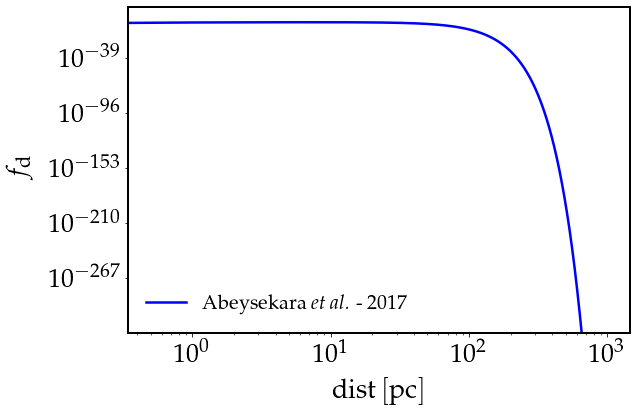

In [72]:
# Plot function from formula S8 in Abeysekara et al 2017. To describe TeV gamma-ray morphology

d = np.linspace(start=0., stop=1000., num=2000)
def func(d_):
    return d_ * 1.22 / ( np.pi**(3/2) * r_d * (d_ + 0.06*r_d) ) * np.exp(- d_**2 / r_d**2)

plt.figure(figsize=(9, 6))

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7
ax.yaxis.labelpad = 15

plt.loglog(d, func(d), lw=2.5, color='blue', label='Abeysekara \\textit{et al.} - 2017')

plt.legend(frameon=False, fontsize = 20)
plt.xlabel('$\mathrm{dist} \, \mathrm{[pc]}$', fontsize=27)
plt.ylabel('$f_{\mathrm{d}}$', fontsize=27)
plt.show()

# Particle containment

In [6]:
Geminga_distance = 250*conv_pc_cm # Distance to Earth in cm

theta_d = 5.5 # Deg  -- Value measured! From Abeysekara 2017
tau_cool = 8e3 # yr # For 100 TeV halo
r_d_Diff = 2*np.sqrt(np.interp(1e5, E, D)*tau_cool*conv_yr_sec)*conv_cm_pc
r_d = theta_d*np.pi/180 *(Geminga_distance)*conv_cm_pc
print('Measured size for gamma-ray emission of the Geminga TeV halo at 100 TeV:', r_d, 
      'pc\n', 'Expected size of a TeV halo with standard diffusion coefficient:', r_d_Diff, 'pc')

Measured size for gamma-ray emission of the Geminga TeV halo at 100 TeV: 23.995013449220803 pc
 Expected size of a TeV halo with standard diffusion coefficient: 431.93378805017016 pc


In [78]:
# Formulas for the TeV gamma-ray morphology. Formulas S8 and S11 in Abeysakara et al paper

def f_theta_t(theta, r):
    return 1.22/(np.pi**(3/2) * theta_df(r) * (theta + 0.06*theta_df(r)) ) * np.exp(-theta**2/theta_df(r)**2) * theta

def f_theta_r(r, th):
    return 1.22/(np.pi**(3/2) * r_df(th) * (r + 0.06*r_df(th)) ) * np.exp(-r**2/r_df(th)**2) * r

def r_df(thet):
    return thet*np.pi/180 *(Geminga_distance)*conv_cm_pc

def theta_df(r):
    return 180/np.pi*r/((Geminga_distance)*conv_cm_pc)

In [83]:
tot_flux = 0
flux_d = 0
for it in range(100):
    tot_flux += f_theta_r(it, theta_d)
for it in np.arange(r_d+1):
    flux_d += f_theta_r(it, theta_d) 
print('Flux contained into the reported size of Geminga (5.5 degrees):', flux_d/tot_flux*100, '%')

Flux contained into the reported size of Geminga (5.5 degrees): 82.67214884113372 %


In [99]:
flux_d = 0
size_68 = 19
for it in np.arange(size_68):
    flux_d += f_theta_r(it, theta_d) 
    
print('Flux contained within', size_68, 'pc is: ' + str(np.round(flux_d/tot_flux, 3)) + '% ~ 1 sigma' )
print(size_68, 'pc are', np.round(theta_df(size_68), 2), 'degrees')

Flux contained within 19 pc is: 0.682% ~ 1 sigma
19 pc are 4.36 degrees


In [98]:
flux_d = 0
size_50 = 14
for it in np.arange(size_50):
    flux_d += f_theta_r(it, theta_d) 
    
print('Flux contained within', size_50, 'pc is: ' + str(np.round(flux_d/tot_flux, 3)) + '%' )
print(size_50, 'pc are', np.round(theta_df(size_50), 2), 'degrees')

Flux contained within 14 pc is: 0.514%
14 pc are 3.21 degrees


In [97]:
flux_d = 0
size_90 = 30
for it in np.arange(size_90):
    flux_d += f_theta_r(it, theta_d) 
    
print('Flux contained within', size_90, 'pc is: ' + str(np.round(flux_d/tot_flux, 3)) + '%' )
print(size_90, 'pc are', np.round(theta_df(size_90), 2), 'degrees')

Flux contained within 30 pc is: 0.904% ~ 2 sigma
30 pc are 6.88 degrees


In [106]:
flux_d = 0
size_99 = 51
for it in np.arange(size_99):
    flux_d += f_theta_r(it, theta_d) 
    
print('Flux contained within', size_99, 'pc is: ' + str(np.round(flux_d/tot_flux, 3)) + '% ~ 3 sigma' )
print(size_99, 'pc are', np.round(theta_df(size_99), 2), 'degrees')

Flux contained within 51 pc is: 0.997% ~ 3 sigma
51 pc are 11.69 degrees


# Energetics

# <center>Injection from the source
    
$$
\begin{align}
Q(E, \vec{r}) = Q_0 \left( \frac{E}{E_0} \right)^{-\alpha} exp\left[-\frac{E}{E_c}\right] \,\,\delta(\vec{r})\\[10 pt]
L(t) = L_0 \cdot \left(\frac{1}{(1+t/\tau_0)}\right)^{-(n+1)/(n-1)}
\end{align}
$$

In [4]:
alpha = -1.6 #
Ec = 2.e5  # GeV 
Brakn = 3
tau_0 = 1.2e4*conv_yr_sec # 12 kyr -> seconds
eta = 0.2
Edot = 3.2e34 # erg/s  # Geminga-like. Taken from various references, among them arXiv:2107.07395v1 
tstar = 3.42e5*conv_yr_sec #kyr -> seconds
L_0 = Edot/(1+(tstar/tau_0))**(-(Brakn+1)/(Brakn-1)) *conv_erg_GeV  # erg/s -> GeV/s
Q_0 = 3.2e-3                 #Particles injected/GeV^2
Emax = 1e10
Emin = 0.01
Ekin_fac = 1.1
dimE = int( (np.log(Emax) - np.log(Emin)) / np.log(Ekin_fac)) + 2 # I added another more point to pass E_max!
#print(dimE)
E = [Emin*(Ekin_fac**i) for i in range(0,dimE)]
E = np.array(E)
dE = (np.append(E[1:], Emin*(Ekin_fac**dimE)) - E)/E

In [11]:
Edot/(1+(tstar/tau_0))**(-(Brakn+1)/(Brakn-1))

2.7847999999999995e+37

In [12]:
Geminga_age = 342*1e3# yr
tt = np.arange(1, Geminga_age)
L = L_0*(1+tt*conv_yr_sec/tau_0)**(-(Brakn+1)/(Brakn-1))  # GeV/s
Q = Q_0*((E)**(alpha))*np.exp(-E/Ec)                      # particles injected/GeV^2

## The product L_0*Q_0 gives units of [particles/(GeV s)]

print('Integral of L ([GeV/s]) in time:', np.sum((1+tt*conv_yr_sec/tau_0)**(-(Brakn+1)/(Brakn-1))*conv_yr_sec), 
      '[GeV] -- Spin down energy of the pulsar until today')  ##yr
print('Integral of Q ([GeV^-2]) in energy:',np.sum(Q_0*((E)**(alpha))*np.exp(-E/Ec)*dE*E), '[GeV^-1]') # equiv to dN/dE
print('Number of particles injected in the energy range from {} GeV to {} TeV:'.format(Emin, Emax*1e-3),
      np.sum(Q_0*((E)**(alpha))*np.exp(-E/Ec)*E*dE*E))

Integral of L ([GeV/s]) in time: 365634381808.33417 [GeV] -- Spin down energy of the pulsar until today
Integral of Q ([GeV^-2]) in energy: 0.09123870702369453 [GeV^-1]
Number of particles injected in the energy range from 0.01 GeV to 10000000.0 TeV: 0.9813824753660045


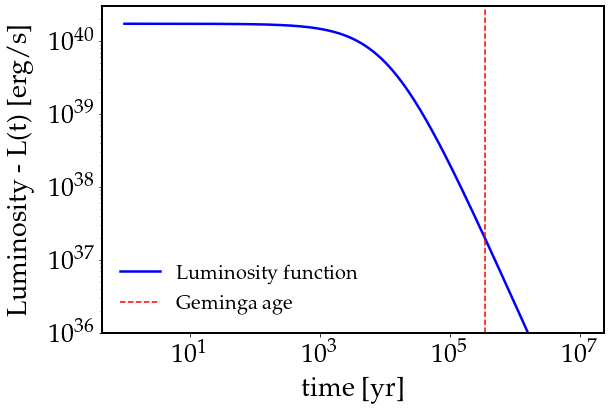

In [13]:
plt.figure(figsize=(9, 6))

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7
ax.yaxis.labelpad = 15

plt.yscale('log')
tt2 = np.arange(1, Geminga_age*30)
plt.loglog(tt2, L_0*(1+tt2*conv_yr_sec/tau_0)**(-(Brakn+1)/(Brakn-1)),
           lw=2.5, color='blue', label='Luminosity function')
plt.axvline(x=Geminga_age, c='r', linestyle='dashed', label='Geminga age')
plt.legend(frameon=False, fontsize = 20)
plt.xlabel('time [yr]', fontsize=27)
plt.ylabel('Luminosity - L(t) [erg/s]', fontsize=27)
plt.ylim(bottom =1e36, top =3e40) 
plt.show()

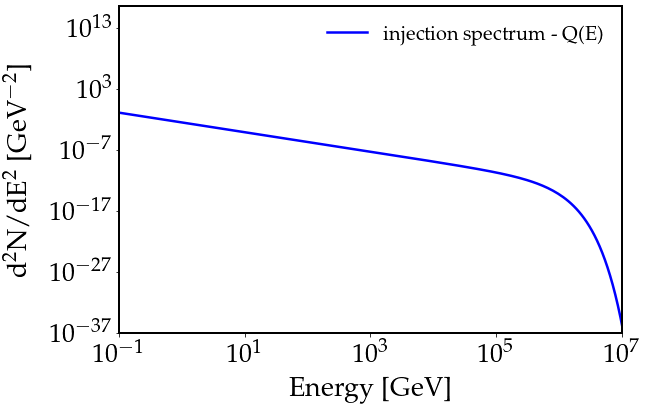

In [14]:
plt.figure(figsize=(9, 6))

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7
ax.yaxis.labelpad = 15

plt.yscale('log')
plt.xscale('log')
plt.loglog(E, Q, lw=2.5, color='blue', label='injection spectrum - Q(E)')
plt.legend(frameon=False, fontsize = 20)
plt.xlabel('Energy [GeV]', fontsize=27)
plt.ylabel(r'd$^2$N/dE$^2$ [GeV$^{-2}$]', fontsize=27)
plt.ylim(bottom =1e-37) 
plt.xlim(right = 1e7, left = 0.1)
plt.show()

# <center>           Initial spind down energy
\begin{align} \int^{\inf}_{0.1~\small{GeV}} L_0 Q(E) E dE\, =\, \int^{\inf}_{0.1~\small{GeV}} L_0 Q_0 \left(\frac{E}{1~\small{GeV}}\right)^{-\alpha}e^{-E/E_c} E dE\, =\, W_0
\end{align}
$\alpha = 1.6 \, ; \, E_c = 2e5\, GeV$

$L_0 \, \text{is fixed to the initial spin down energy:}\, L_0= 3.2e34 \,erg/s$

$Q_0 \, \text{is used to normalize the predicted gamma-ray flux to the HAWC flux:} \, Q_0 \sim 3.2\cdot10^{-3} \,(GeV^{-2})$

In [15]:
##Ruo-Yu's W value
print('Ruo-Yu initial spin down power:  W_0 =', 3.6e47*2.78e37/1.1e49, 'erg/s -->', 
      5e47*2.78e37/1.1e49*conv_erg_GeV, 'erg/s \nAbeysakara best-fit value:  W_0 =', 
      2.8e37, 'erg/s -->', 2.8e37*conv_erg_GeV, 'GeV/s')

Ruo-Yu initial spin down power:  W_0 = 9.098181818181817e+35 erg/s --> 7.886998999999998e+38 erg/s 
Abeysakara best-fit value:  W_0 = 2.8e+37 erg/s --> 1.7476227999999998e+40 GeV/s


In [16]:
#Total power in my simulation - Integrated spin down power at t=0
print('Initial spin down power in my simulation', np.sum((L_0* Q_0*((E)**(alpha))*np.exp(-E/Ec))*E*dE*E), 'GeV/s')

Initial spin down power in my simulation 1.7057759204986583e+40 GeV/s


# <center>Total energy budget of the source
    
$$
\begin{align}
E_{\mathrm{tot}} &= W = \int d^3 \vec{r} \int^{t_{\mathrm{age}}}_{t_{\mathrm{rel}}(E)} dt \int_0^{+ \infty} dE \, E \cdot L(t)\, Q(E, \vec{r})\, = L_0 \, E_0^2 \, Q_0 \cdot \tau_{\mathrm{d}} \int^{t_{\mathrm{age}}}_{t_{\mathrm{rel}}(\omega)} dz \, \frac{1}{\left( 1 + z \right)^{\alpha}} \int^{+ \infty}_{0} d\omega \cdot \omega^{-\Gamma_{\mathrm{inj}} + 1 }  \\[10 pt]
&= N_0 \cdot \tau_{\mathrm{d}} \int^{t_{\mathrm{age}}}_{t_{\mathrm{rel}}(\omega)} dz \, \frac{1}{\left( 1 + z \right)^{\alpha}} \int^{+ \infty}_{0} d\omega \cdot \omega^{-\Gamma_{\mathrm{inj}} + 1 }
\end{align}
$$

In [10]:
Geminga_age = 342*1e3# yr
tt = np.arange(1, Geminga_age)
L = L_0*(1+tt*conv_yr_sec/tau_0)**(-(Brakn+1)/(Brakn-1))  # GeV/s
Q = Q_0*((E)**(alpha))*np.exp(-E/Ec)                      # particles injected/GeV^2

## The product L_0*Q_0 gives units of [particles/(GeV s)]

print('Integral of L ([GeV/s]) in time:', np.sum((1+tt*conv_yr_sec/tau_0)**(-(Brakn+1)/(Brakn-1))*conv_yr_sec), 
      '[GeV] -- Spin down energy of the pulsar until today')  ##yr
print('Integral of Q ([GeV^-2]) in energy:',np.sum(Q_0*((E)**(alpha))*np.exp(-E/Ec)*dE*E), '[GeV^-1]') # equiv to dN/dE
print('Number of particles injected in the energy range from {} GeV to {} TeV:'.format(Emin, Emax*1e-3),
      np.sum(Q_0*((E)**(alpha))*np.exp(-E/Ec)*E*dE*E))

Integral of L ([GeV/s]) in time: 365634381808.33417 [GeV] -- Spin down energy of the pulsar until today
Integral of Q ([GeV^-2]) in energy: 0.09123870702369453 [GeV^-1]
Number of particles injected in the energy range from 0.01 GeV to 10000000.0 TeV: 0.9813824753660045


In [17]:
print('Luminosity today:', L_0*conv_GeV_erg, 'erg/s')

Luminosity today: 2.7847999999999995e+37 erg/s


In [42]:
def func(omega_):
    return omega_**(-gamma + 1) * np.exp( -(E_0_erg / E_c_erg)*omega_ )

def func_time(z_):
    return 1. / (1 + z_)**nra


conv_GeV_erg = 0.00160218
conv_s_yr = 3.17e-8


E_0 = 1.      # in [GeV]
E_0_erg = E_0*conv_GeV_erg
E_c_erg = Ec*conv_GeV_erg
gamma = 1.6
tau_0 = 12.e+3   # in [yr]
nra = 2.
norm = L_0*Q_0  # in [GeV^{-1} s^{-1}]
norm_erg_yr = norm / (conv_GeV_erg * conv_s_yr)

I, err = quad(func, 0.01, 1.e+8) # GeV
#I, err = quad(func, 8000, 40000) # GeV
I_time, err_time = quad(func_time, 0., 342.e+3 / tau_0) #yr

#print('integral =', I)
print('current normalization (L_0 x Q_0) =', norm_erg_yr, '[erg^{-1} yr^{-1}] or', norm, '[GeV^{-1} s^{-1}]')
print('Geminga-like normalization (L_0 x Q_0) =', W_e / (tau_0 * (I*I_time) * E_0_erg**2), '[erg^{-1} yr^{-1}]')
print('')
print('Total energy budget in the simulation=', tau_0 * (I*I_time) * norm_erg_yr * E_0_erg**2, '[erg]')

W_e = 1.1e+49   # in [erg]
#norm_gem = W_e / (tau_0 * (I*I_time) * E_0_erg**2)

print('Geminga energy budget=', W_e, '[erg] - We need an extra factor of:', 
      W_e/(tau_0 * (I*I_time) * norm_erg_yr * E_0_erg**2))
#print('Geminga L_0*Q_0 =', norm_gem * (conv_GeV_erg * conv_s_yr), '[GeV^{-1} s^{-1}]')

current normalization (L_0 x Q_0) = 1.095123480881904e+48 [erg^{-1} yr^{-1}] or 5.562034255359999e+37 [GeV^{-1} s^{-1}]
Geminga-like normalization (L_0 x Q_0) = 1.2628774378930008e+48 [erg^{-1} yr^{-1}]

Total energy budget in the simulation= 9.538818200600075e+48 [erg]
Geminga energy budget= 1.1e+49 [erg] - We need an extra factor of: 1.1531826866464447


In [44]:
print('My Q_0 is:', Q_0, 'and that from Geminga halo is:', W_e / (tau_0 * (I*I_time) * E_0_erg**2) * (conv_GeV_erg * conv_s_yr)/L_0)

My Q_0 is: 0.0032 and that from Geminga halo is: 0.003690184597268624
